In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

from samplers import CGSSKernel

import numpy as np
from scipy.signal import correlate
import matplotlib.pyplot as plt

from collections import namedtuple

## Gram-Schmidt for conjugate directions

$$\begin{align}
v_i = u_i + \sum_{j = 1}^{i - 1} \beta_{ij} v_j.
\end{align}$$

where $v_0 = u_0$ and $\beta_{ij}$ are appropriately chosen constants such that $d_i A d_j = 0$ whenever $i \neq j$

$$\begin{align}
\beta_{ij} = - \frac{u_i^\top A v_j}{v_j^\top A v_j}.
\end{align}$$

In [2]:
def f_to_f_with_gradients(f):
    
    def f_with_gradients(x, *args):
        
        result = None
        
        with tf.GradientTape() as tape:
        
            tape.watch(x)
        
            result = f(x, *args)
        
        gradients = tape.gradient(result, x)
    
        return result, gradients
    
    return f_with_gradients


def quadratic(x, mean, cov):
    
    N = mean.shape[0]
    
    diff = x - mean
    prec_diff = tf.linalg.solve(cov, diff)
    log_prob = - 0.5 * tf.reduce_sum(diff * prec_diff, axis=0)
    
    return log_prob


def mixture_of_gaussians(x, mean1, mean2, cov, mix_prob):
    
    diff1 = x - mean1
    prec_diff1 = tf.linalg.solve(cov, diff1)
    quad1 = - 0.5 * tf.reduce_sum(diff1 * prec_diff1, axis=0)
    
    diff2 = x - mean2
    prec_diff2 = tf.linalg.solve(cov, diff2)
    quad2 = - 0.5 * tf.reduce_sum(diff2 * prec_diff2, axis=0)
    
    log_prob = tf.math.log(mix_prob * tf.math.exp(quad1) + (1 - mix_prob) * tf.exp(quad2))
    
    return log_prob


def radial_bump(x, mean, width, r0):
    
    r = tf.reduce_sum((x - mean) ** 2 + 1e-6, axis=0) ** 0.5
    
    log_prob = tf.math.log(r) - ((r - r0) / width) ** 2
    
    return log_prob


def funnel(x_):
    
    # First dimension of x_ is v, rest are x
    v = x_[:1, :]
    x = x_[1:, :]
    
    # Variance of x
    xvar = tf.exp(v)
    
    # Log probability of v and x
    log_prob = - 0.5 * (tf.math.log(2 * np.pi) + v ** 2)
    log_prob = - 0.5 * (tf.math.log(2 * np.pi * xvar) + tf.reduce_sum(x ** 2 / xvar, axis=0, keepdims=True))
    
    return log_prob
    
    
def autocorrelation(x):
    return correlate(x, x) - np.mean(x) ** 2

tf.Tensor(-0.8240983, shape=(), dtype=float32) tf.Tensor(0.1216234, shape=(), dtype=float32)


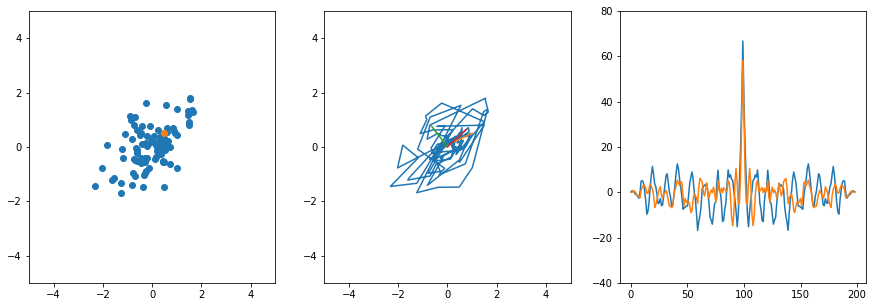

In [3]:
num_results = 100
init_state = tf.transpose(tf.convert_to_tensor([[1.0, 0.5]]))
mean = tf.zeros((2, 1))
cov = tf.convert_to_tensor([[1.0, 0.6],
                            [0.6, 0.8]])

log_prob_ = f_to_f_with_gradients(quadratic)
log_prob = lambda x : log_prob_(x, mean, cov)

states = tfp.mcmc.sample_chain(num_results=num_results,
                               current_state=init_state,
                               kernel=CGSSKernel(log_prob, reset_every=2),
                               num_burnin_steps=0,
                               num_steps_between_results=0,
                               trace_fn=None)

log_probs = tf.convert_to_tensor([log_prob(state)[0] for state in states])
print(tf.reduce_mean(log_probs), tf.reduce_mean(log_probs ** 2) ** 0.5 / states.shape[0] ** 0.5)

# diffs = tf.transpose(states[1:, :, 0] - states[:-1, :, 0])
# inner_prod = tf.matmul(diffs, tf.linalg.solve(cov, diffs), transpose_a=True)
# print(inner_prod)

states_ = np.array(states)[:, :, 0]
eigval, eigvec = tf.linalg.eig(cov)
eigvec = np.real(np.array(eigvec))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(states_[:, 0], states_[:, 1])
init_state = np.array(init_state)
plt.scatter([init_state[1, 0]], [init_state[1, 0]])

plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.subplot(1, 3, 2)
plt.plot(states_[:, 0], states_[:, 1])
plt.plot([states_[0, 0], init_state[0]], [states_[0, 1], init_state[1]])
plt.plot([0, eigvec[0, 0]], [0, eigvec[0, 1]])
plt.plot([0, eigvec[1, 0]], [0, eigvec[1, 1]])

plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.subplot(1, 3, 3)
corr1 = correlate(states_[:, 0], states_[:, 0])
corr1 = corr1 - np.mean(states_[:, 0]) ** 2
plt.plot(corr1)
corr2 = correlate(states_[:, 1], states_[:, 1])
corr2 = corr2 - np.mean(states_[:, 1]) ** 2
plt.plot(corr2)
plt.ylim([-40, 80])

plt.show()

tf.Tensor(-0.85376066, shape=(), dtype=float32) tf.Tensor(0.10735053, shape=(), dtype=float32)


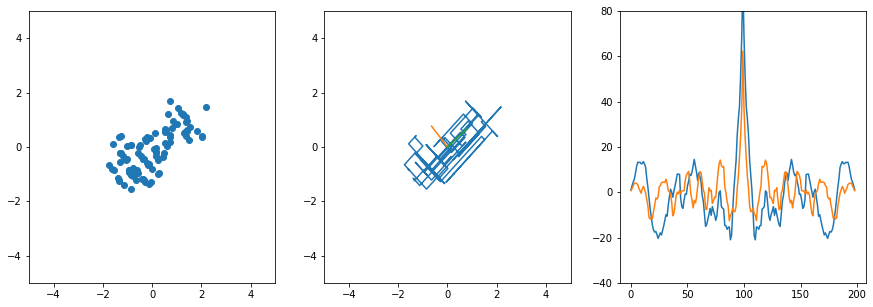

In [4]:
num_results = 100
init_state = tf.transpose(tf.convert_to_tensor([[1.0, 0.5]]))
mean = tf.zeros((2, 1))
cov = tf.convert_to_tensor([[1.0, 0.6],
                            [0.6, 0.8]])

log_prob_ = f_to_f_with_gradients(quadratic)
log_prob = lambda x : log_prob_(x, mean, cov)[0]

states = tfp.mcmc.sample_chain(num_results=num_results,
                               current_state=init_state,
                               kernel=tfp.mcmc.SliceSampler(target_log_prob_fn=log_prob,
                                                            step_size=1.0,
                                                            max_doublings=5),
                               num_burnin_steps=0,
                               num_steps_between_results=0,
                               trace_fn=None)

log_probs = tf.convert_to_tensor([log_prob(state)[0] for state in states])
print(tf.reduce_mean(log_probs), tf.reduce_mean(log_probs ** 2) ** 0.5 / states.shape[0] ** 0.5)

# diffs = tf.transpose(states[1:, :, 0] - states[:-1, :, 0])
# inner_prod = tf.matmul(diffs, tf.linalg.solve(cov, diffs), transpose_a=True)
# print(inner_prod)

states_ = np.array(states)[:, :, 0]
eigval, eigvec = tf.linalg.eig(cov)
eigvec = np.real(np.array(eigvec))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(states_[:, 0], states_[:, 1])
plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.subplot(1, 3, 2)
plt.plot(states_[:, 0], states_[:, 1])
plt.plot([0, eigvec[0, 0]], [0, eigvec[0, 1]])
plt.plot([0, eigvec[1, 0]], [0, eigvec[1, 1]])

plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.subplot(1, 3, 3)
plt.plot(correlate(states_[:, 0], states_[:, 0]) - np.mean(states_[:, 0]) ** 2)
plt.plot(correlate(states_[:, 1], states_[:, 1]) - np.mean(states_[:, 1]) ** 2)
plt.ylim([-40, 80])

plt.show()

# Checking Nd slice sampling

In [10]:
num_results = 500
dim = 10
init_state = tf.random.normal(shape=(dim, 1))
mean = tf.random.normal(shape=(dim, 1))
cov = tf.random.normal(shape=(dim, dim))
cov = tf.eye(dim) + tf.matmul(cov, cov, transpose_b=True)

log_prob_ = f_to_f_with_gradients(quadratic)
log_prob = lambda x : log_prob_(x, mean, cov)

states_cdcs = tfp.mcmc.sample_chain(num_results=num_results,
                                    current_state=init_state,
                                    kernel=CGSSKernel(log_prob, reset_every=dim//2),
                                    num_burnin_steps=0,
                                    num_steps_between_results=0,
                                    trace_fn=None)

log_probs = tf.convert_to_tensor([log_prob(state)[0] for state in states_cdcs])
print(tf.reduce_mean(log_probs),
      tf.reduce_mean(log_probs ** 2) ** 0.5 / states_cdcs.shape[0] ** 0.5)

tf.Tensor(-3.1097176, shape=(), dtype=float32) tf.Tensor(0.16260275, shape=(), dtype=float32)


In [11]:
log_prob_ = f_to_f_with_gradients(quadratic)
log_prob = lambda x : log_prob_(x, mean, cov)[0]

states_vanilla = tfp.mcmc.sample_chain(num_results=num_results,
                                       current_state=init_state,
                                       kernel=tfp.mcmc.SliceSampler(target_log_prob_fn=log_prob,
                                                                    step_size=1.0,
                                                                    max_doublings=5),
                                       num_burnin_steps=0,
                                       num_steps_between_results=0,
                                       trace_fn=None)

log_probs = tf.convert_to_tensor([log_prob(state)[0] for state in states_vanilla])
print(tf.reduce_mean(log_probs),
      tf.reduce_mean(log_probs ** 2) ** 0.5 / states_vanilla.shape[0] ** 0.5)

tf.Tensor(-5.3534346, shape=(), dtype=float32) tf.Tensor(0.27318507, shape=(), dtype=float32)


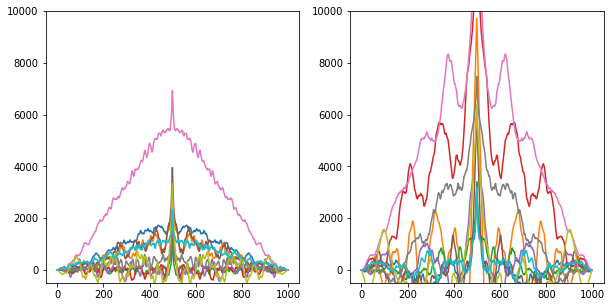

In [12]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
for i in range(dim): plt.plot(autocorrelation(states_cdcs[:, i]))
plt.ylim([-500, 10000])

plt.subplot(122)
for i in range(dim): plt.plot(autocorrelation(states_vanilla[:, i]))
plt.ylim([-500, 10000])

plt.show()

In [13]:
tf.reduce_sum(tfp.mcmc.effective_sample_size(states_cdcs))

<tf.Tensor: shape=(), dtype=float32, numpy=496.3851>

In [14]:
tf.reduce_sum(tfp.mcmc.effective_sample_size(states_vanilla))

<tf.Tensor: shape=(), dtype=float32, numpy=166.43619>

## Sampling from a mixture of two Gaussians

In [ ]:
num_results = 500
init_state = tf.transpose(tf.convert_to_tensor([[-3.1, -0.1]]))
mean1 = tf.transpose(tf.convert_to_tensor([[-3.0, 0.0]]))
mean2 = tf.transpose(tf.convert_to_tensor([[3.0, 0.0]]))
cov = tf.convert_to_tensor([[1.0, 0.5],
                            [0.5, 1.0]])
mix_prob = 0.5

log_prob_ = f_to_f_with_gradients(mixture_of_gaussians)
log_prob = lambda x : log_prob_(x, mean1, mean2, cov, mix_prob)[0]

states_vanilla = tfp.mcmc.sample_chain(num_results=num_results,
                                       current_state=init_state,
                                       kernel=tfp.mcmc.SliceSampler(target_log_prob_fn=log_prob,
                                                                    step_size=1.0,
                                                                    max_doublings=5),
                                       num_burnin_steps=0,
                                       num_steps_between_results=0,
                                       trace_fn=None)

states_ = np.array(states_vanilla)[:, :, 0]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(states_[:, 0], states_[:, 1])
init_state = np.array(init_state)
plt.scatter([init_state[1, 0]], [init_state[1, 0]])

plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.subplot(1, 3, 2)
plt.plot(states_[:, 0], states_[:, 1])
plt.plot([states_[0, 0], init_state[0]], [states_[0, 1], init_state[1]])

plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.subplot(1, 3, 3)
corr1 = correlate(states_[:, 0], states_[:, 0])
corr1 = corr1 - np.mean(states_[:, 0]) ** 2
plt.plot(corr1)
corr2 = correlate(states_[:, 1], states_[:, 1])
corr2 = corr2 - np.mean(states_[:, 1]) ** 2
plt.plot(corr2)
plt.show()

In [ ]:
num_results = 500
init_state = tf.transpose(tf.convert_to_tensor([[-3.1, -0.1]]))
mean1 = tf.transpose(tf.convert_to_tensor([[-3.0, 0.0]]))
mean2 = tf.transpose(tf.convert_to_tensor([[3.0, 0.0]]))
cov = tf.convert_to_tensor([[1.0, 0.5],
                            [0.5, 1.0]])

mix_prob = 0.5

log_prob_ = f_to_f_with_gradients(mixture_of_gaussians)
log_prob = lambda x : log_prob_(x, mean1, mean2, cov, mix_prob)

states_cdcs = tfp.mcmc.sample_chain(num_results=num_results,
                                    current_state=init_state,
                                    kernel=CGSSKernel(log_prob, reset_every=1),
                                    num_burnin_steps=0,
                                    num_steps_between_results=0,
                                    trace_fn=None)

states_ = np.array(states_cdcs)[:, :, 0]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(states_[:, 0], states_[:, 1])
init_state = np.array(init_state)
plt.scatter([init_state[1, 0]], [init_state[1, 0]])

plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.subplot(1, 3, 2)
plt.plot(states_[:, 0], states_[:, 1])
plt.plot([states_[0, 0], init_state[0]], [states_[0, 1], init_state[1]])

plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.subplot(1, 3, 3)
corr1 = correlate(states_[:, 0], states_[:, 0])
corr1 = corr1 - np.mean(states_[:, 0]) ** 2
plt.plot(corr1)
corr2 = correlate(states_[:, 1], states_[:, 1])
corr2 = corr2 - np.mean(states_[:, 1]) ** 2
plt.plot(corr2)
plt.show()

In [ ]:
tf.reduce_sum(tfp.mcmc.effective_sample_size(states_cdcs))

In [ ]:
tf.reduce_sum(tfp.mcmc.effective_sample_size(states_vanilla))

# Sampling from radial bump

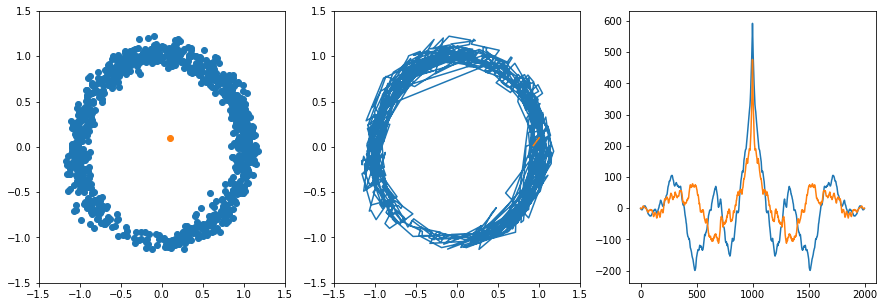

In [11]:
num_results = 1000
mean = tf.zeros((2, 1))
width = tf.convert_to_tensor(0.1)
r0 = tf.convert_to_tensor(1.0)

init_state = tf.transpose(tf.convert_to_tensor([[r0, 1e-1]]))

log_prob_ = f_to_f_with_gradients(radial_bump)
log_prob = lambda x : log_prob_(x, mean, width, r0)

states_cdss = tfp.mcmc.sample_chain(num_results=num_results,
                                    current_state=init_state,
                                    kernel=CGSSKernel(log_prob, reset_every=2),
                                    num_burnin_steps=0,
                                    num_steps_between_results=0,
                                    trace_fn=None)

states_ = np.array(states_cdss)[:, :, 0]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(states_[:, 0], states_[:, 1])
init_state = np.array(init_state)
plt.scatter([init_state[1, 0]], [init_state[1, 0]])

plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])

plt.subplot(1, 3, 2)
plt.plot(states_[:, 0], states_[:, 1])
plt.plot([states_[0, 0], init_state[0]], [states_[0, 1], init_state[1]])

plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])

plt.subplot(1, 3, 3)
corr1 = correlate(states_[:, 0], states_[:, 0])
corr1 = corr1 - np.mean(states_[:, 0]) ** 2
plt.plot(corr1)
corr2 = correlate(states_[:, 1], states_[:, 1])
corr2 = corr2 - np.mean(states_[:, 1]) ** 2
plt.plot(corr2)
plt.show()

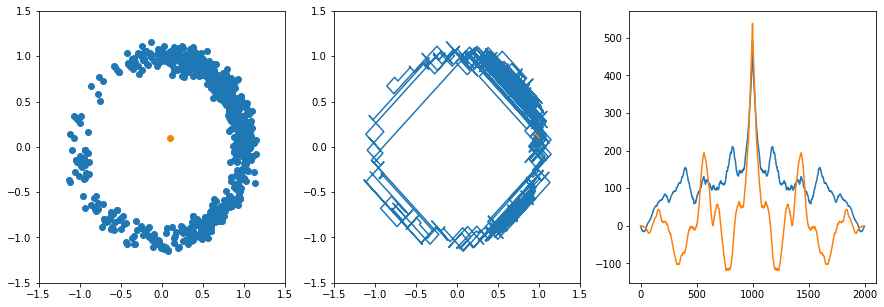

In [12]:
log_prob_ = f_to_f_with_gradients(radial_bump)
log_prob = lambda x : log_prob_(x, mean, width, r0)[0]

states_vanilla = tfp.mcmc.sample_chain(num_results=num_results,
                                       current_state=init_state,
                                       kernel=tfp.mcmc.SliceSampler(target_log_prob_fn=log_prob,
                                                                    step_size=1.0,
                                                                    max_doublings=5),
                                       num_burnin_steps=0,
                                       num_steps_between_results=0,
                                       trace_fn=None)

states_ = np.array(states_vanilla)[:, :, 0]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(states_[:, 0], states_[:, 1])
init_state = np.array(init_state)
plt.scatter([init_state[1, 0]], [init_state[1, 0]])

plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])

plt.subplot(1, 3, 2)
plt.plot(states_[:, 0], states_[:, 1])
plt.plot([states_[0, 0], init_state[0]], [states_[0, 1], init_state[1]])

plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])

plt.subplot(1, 3, 3)
corr1 = correlate(states_[:, 0], states_[:, 0])
corr1 = corr1 - np.mean(states_[:, 0]) ** 2
plt.plot(corr1)
corr2 = correlate(states_[:, 1], states_[:, 1])
corr2 = corr2 - np.mean(states_[:, 1]) ** 2
plt.plot(corr2)
plt.show()

In [22]:
tfp.mcmc.effective_sample_size(states_cdss)

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[11.640684],
       [16.450586]], dtype=float32)>

In [23]:
tfp.mcmc.effective_sample_size(states_vanilla)

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[26.686853],
       [15.863936]], dtype=float32)>

# Sampling from high-dimensional radial bump

In [36]:
num_results = 100
dim = 5
mean = tf.zeros((dim, 1))
width = tf.convert_to_tensor(0.2)
r0 = tf.convert_to_tensor(1.0)

init_state = tf.convert_to_tensor([[r0]] + [[0.0]] * (dim - 1)) + (width / dim ** 0.5) * tf.random.normal(shape=(dim, 1))

log_prob_ = f_to_f_with_gradients(radial_bump)
log_prob = lambda x : log_prob_(x, mean, width, r0)

states_cdss = tfp.mcmc.sample_chain(num_results=num_results,
                                    current_state=init_state,
                                    kernel=CGSSKernel(log_prob, reset_every=10),
                                    num_burnin_steps=0,
                                    num_steps_between_results=0,
                                    trace_fn=None)

InvalidArgumentError: Input matrix is not invertible. [Op:MatrixSolve]

In [37]:
log_prob_ = f_to_f_with_gradients(radial_bump)
log_prob = lambda x : log_prob_(x, mean, width, r0)[0]

states_vanilla = tfp.mcmc.sample_chain(num_results=num_results,
                                       current_state=init_state,
                                       kernel=tfp.mcmc.SliceSampler(target_log_prob_fn=log_prob,
                                                                    step_size=1.0,
                                                                    max_doublings=5),
                                       num_burnin_steps=0,
                                       num_steps_between_results=0,
                                       trace_fn=None)

In [38]:
tf.reduce_sum(tfp.mcmc.effective_sample_size(states_cdss))

<tf.Tensor: shape=(), dtype=float32, numpy=82.47604>

In [39]:
tf.reduce_sum(tfp.mcmc.effective_sample_size(states_vanilla))

<tf.Tensor: shape=(), dtype=float32, numpy=91.22833>

# Sampling from funnel distribution

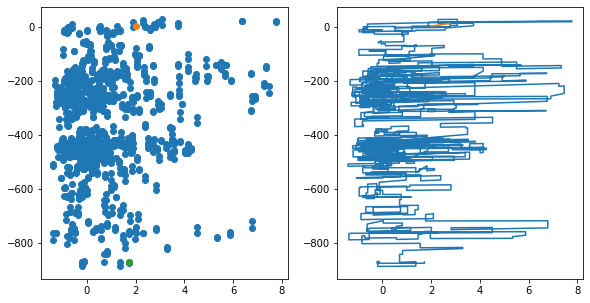

In [48]:
num_results = 1000
init_state = tf.transpose(tf.convert_to_tensor([[1., 1.]]))
log_prob = f_to_f_with_gradients(funnel)

states_cdss = tfp.mcmc.sample_chain(num_results=num_results,
                                    current_state=init_state,
                                    kernel=CGSSKernel(log_prob, reset_every=2),
                                    num_burnin_steps=0,
                                    num_steps_between_results=0,
                                    trace_fn=None)

states_ = np.array(states_cdss)[:, :, 0]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(states_[:, 0], states_[:, 1])
init_state = np.array(init_state)
plt.scatter([init_state[1, 0]], [init_state[1, 0]])
plt.scatter(states_[-1, 0], states_[-1, 1])

plt.subplot(1, 3, 2)
plt.plot(states_[:, 0], states_[:, 1])
plt.plot([states_[0, 0], init_state[0]], [states_[0, 1], init_state[1]])

# plt.subplot(1, 3, 3)
# corr1 = correlate(states_[:, 0], states_[:, 0])
# corr1 = corr1 - np.mean(states_[:, 0]) ** 2
# plt.plot(corr1)
# corr2 = correlate(states_[:, 1], states_[:, 1])
# corr2 = corr2 - np.mean(states_[:, 1]) ** 2
# plt.plot(corr2)
plt.show()

# Notes

- CDCS can fail if $d$ is zero.
- Finite differences must be handled with care.
- Handle the case when $A$ is zero, or close to zero.
- Think about ergodicity, interleave with random choices of $d$.

# General Roadmap

- Check how the TFP slice sampler picks its directions in higher $N$.
- Eliptical slice sampling
- Experiments
    - Hand-crafted multivariate Gaussian (low and high dimensions, poorly and well conditioned)
    - Randomly chosen multivariate Gaussian (low and high dimensions)
    - Radial bump distribution (low and high dimensions, varying sizes of $r_0$ and $w$
    - Thin filament-like distribution
    - High-dimensional example like LDA
    - Funnel distribution
    - GP hyperparameter posterior
    - Bayesian Neural Network posterior
    
    
- Metrics:
    - ESS and ESS/sec
    - \# objective evals
    - qualitative inspection
    
    
- Comparisons with:
    - Hit-and-run SS
    - Vanilla Metropolis Hastings
    - HMC
    
    
# Concrete chunks

- Finish off own implementation of 1d slice sampling
- Implement hyperrectangle slice sampling
- Implement reflective slice sampling
- Handle zero $d$ and non-invertible matrices
- Check and remove non-conjugate directions